In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-06 21:13:39.873946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 21:13:39.883548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 21:13:39.893849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [2]:
data = Dataset('8h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if

In [3]:
data

,Timestamp,Real Energy,diff,Product Group,SKU code,Event Code_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Work Center,Event Code_mes,...,DB 2000DBW 56 man counter,DB 700DBW 46 contener counter,DB 301DBW 272 cooling water mandrel outlet,DB 301DBW 274 cooling water mandrel inlet,DB 301DBW 276 mandrel coolng flow,DB 301DBW 96 mandrell movment,DB 30DBW 80 contener position,DB 10DBW 114 cont cooling air flow,MW 46 mikos bigetas,DB 301DBW 166 mikos solinas
0,2022-05-01 08:00:00,1.296980e+08,960.405,{DB3},{1.0},"{99.0, 98.0, 901.0}",2623.0,34.216667,"{S_DAN1, S_SCH4B, S_DAN2}","{99.0, 0.0, 70.0}",...,583.763270,2105.762701,60.452923,56.825165,137.515430,61.475559,19.260832,367.701419,815.862345,310.661308
1,2022-05-01 16:00:00,1.037751e+09,9095.324,{DB3},{1.0},"{99.0, 98.0, 702.0, 0.0, 901.0}",29035.0,365.800000,"{S_DAN1, S_SCH4B, S_DAN2}","{99.0, 70.0}",...,583.763270,2105.762701,60.452923,56.825165,137.515430,61.475559,19.260832,367.701419,815.862345,310.661308
2,2022-05-02 00:00:00,1.037968e+09,3204.544,{DB3},{1.0},"{99.0, 611.0, 98.0, 701.0, 0.0}",11094.0,96.633333,"{S_DAN1, S_SCH4B, S_DAN2}","{99.0, 0.0, 70.0, 7.0}",...,642.808896,2164.808465,45.776542,47.012271,68.075876,65.858601,220.660691,162.428462,813.776111,307.370992
3,2022-05-02 08:00:00,1.038005e+09,708.086,{DB3},{1.0},{1101.0},43200.0,96.633333,"{S_DAN1, S_SCH4B, S_DAN2}","{99.0, 70.0, 7.0}",...,652.000000,2174.000000,26.746179,29.192895,3.000000,73.000000,484.000000,162.428462,813.000000,306.000000
4,2022-05-02 16:00:00,1.038026e+09,665.572,{DB3},{1.0},{1101.0},43200.0,96.633333,"{S_DAN1, S_SCH4B, S_DAN2}","{99.0, 70.0, 7.0}",...,652.000000,2174.000000,27.905112,28.656506,3.000000,73.000000,484.000000,162.428462,813.000000,306.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2022-07-30 00:00:00,1.092483e+09,8500.418,{DB3},"{1.0, 3.0}","{99.0, 98.0, 617.0, 702.0, 401.0, 0.0, 701.0, ...",29055.0,278.016667,"{S_DAN1, S_DAN2, S_SCH4B}","{99.0, 0.0, 70.0}",...,263.096492,20153.094897,68.164373,62.281776,127.581229,79.464677,15.331447,423.777957,815.525921,305.657087
270,2022-07-30 08:00:00,1.092760e+09,8861.907,{DB3},{1.0},"{99.0, 98.0, 702.0, 0.0, 701.0, 710.0, 901.0, ...",30221.0,374.750000,"{S_DAN1, S_DAN2, S_SCH4B}","{99.0, 0.0, 70.0}",...,495.811827,20385.810299,66.563981,60.554459,128.369488,71.063516,15.276455,433.359304,815.334497,302.622519
271,2022-07-30 16:00:00,1.093047e+09,8285.891,{DB3},{1.0},"{99.0, 98.0, 702.0, 0.0, 701.0, 901.0}",25208.0,296.683333,"{S_DAN1, S_DAN2, S_SCH4B}","{99.0, 70.0}",...,710.519885,20622.656541,69.984834,64.211095,126.793713,81.739765,27.146969,435.276614,816.006404,311.234553
272,2022-07-31 00:00:00,1.093177e+09,1395.263,{DB3},{1.0},"{98.0, 0.0, 1102.0}",32309.0,296.683333,"{S_DAN1, S_DAN2, S_SCH4B}","{99.0, 70.0}",...,0.277087,20729.276952,41.897730,42.647122,21.984869,81.650230,646.334639,1.514861,817.918265,305.443934


In [3]:
# data = Dataset('1h')
# data = data.preprocess()
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1   # Number of 15-min we want to look into the future based on the past (Out).
n_past = 3   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(seq, steps, out):
    X, Y = list(), list()
    for i in range(len(seq)):
        end = i + steps
        outi = end + out
        if outi > len(seq)-1:
            break
        seqx, seqy = seq[i:end, 1:], seq[end:outi, 0] # 1 the column number I want to make the prediction
        X.append(seqx)
        Y.append(seqy)
    return np.array(X), np.array(Y)

X_num, Y_num = split_sequence(numerical_data, n_past, n_future) # numerical sequences

# in order to align cat-num, I need to append the target feature to the categorical features
categorical_data.insert(0, 'Energy', numerical_data[:, 0].reshape(-1, 1)) #energy column scaled like the numerical process
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data)[1:], dtype=np.int64)
X_cat, Y_cat = split_sequence(categorical_data.to_numpy(), n_past, n_future) # categorical sequences
Y_cat = Y_cat.astype(np.float64)
X = np.concatenate((X_cat, X_num), axis=-1)

print(X_cat.shape, X_num.shape, Y_num.shape)


# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, Y_num, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp
print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)
del data, categorical_data, numerical_data

       Energy  Duration (sec)  Καθαρές Μηχανοώρες (min)  \
0     960.405          2623.0                 34.216667   
1    9095.324         29035.0                365.800000   
2    3204.544         11094.0                 96.633333   
3     708.086         43200.0                 96.633333   
4     665.572         43200.0                 96.633333   
..        ...             ...                       ...   
269  8500.418         29055.0                278.016667   
270  8861.907         30221.0                374.750000   
271  8285.891         25208.0                296.683333   
272  1395.263         32309.0                296.683333   
273  7645.705         25130.0                286.216667   

     Production Quantity (#)  DB  955DBW    8   in die side  \
0                       50.0                     486.049931   
1                      607.0                     486.049931   
2                      373.0                     429.810382   
3                      352.0           

In [4]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=1200, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.3, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.2, recurrent_dropout= 0.1)))
    model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-8-hour(8h).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=2, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/30


I0000 00:00:1728238582.306908  117112 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728238582.337816  117112 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728238582.337964  117112 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728238582.339013  117112 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 19/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3812 - mae: 0.4969 - mape: 96.7242 

I0000 00:00:1728238591.594096  117623 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3157 - mae: 0.4635 - mape: 2201966.5000
Epoch 1: val_loss improved from inf to 0.09206, saving model to ./models/model-8-hour(8h).keras

Epoch 1: Learning rate is 9.999999747378752e-05
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.3147 - mae: 0.4627 - mape: 2203449.7500 - val_loss: 0.0921 - val_mae: 0.2454 - val_mape: 131.1001
Epoch 2/30
111/115 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1293 - mae: 0.2923 - mape: 2441358.2500
Epoch 2: val_loss improved from 0.09206 to 0.09051, saving model to ./models/model-8-hour(8h).keras

Epoch 2: Learning rate is 9.999999747378752e-05
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1282 - mae: 0.2908 - mape: 2450852.5000 - val_loss: 0.0905 - val_mae: 0.2384 - val_mape: 130.5469
Epoch 3/30
112/115 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1071 - mae: 0.2672 - mape: 1762934.2500
Epoch 3: val_loss did not improve from 0.09051

Epoch 3: Learning rate is 9.999999747378752e-05
115/115 ━━━━━

In [5]:
from keras.models import load_model
# load model

model = load_model('./models/model-8-hour(8h).keras')
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


In [7]:
predictions.shape

(21, 1)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 35))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],35))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 2280.9048995775966
Mean Squared Error (MSE): 8365356.42163503
Root Mean Squared Error (RMSE): 2892.292589216214
R² Score: 0.1731776917031953
Adjusted R² Score: 0.02726787259199437
Median Absolute Error: 1965.1802663083345
Mean Absolute Percentage Error (MAPE): 165.58987396852507 %


/tmp/ipykernel_117112/3235171957.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_117112/3235171957.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


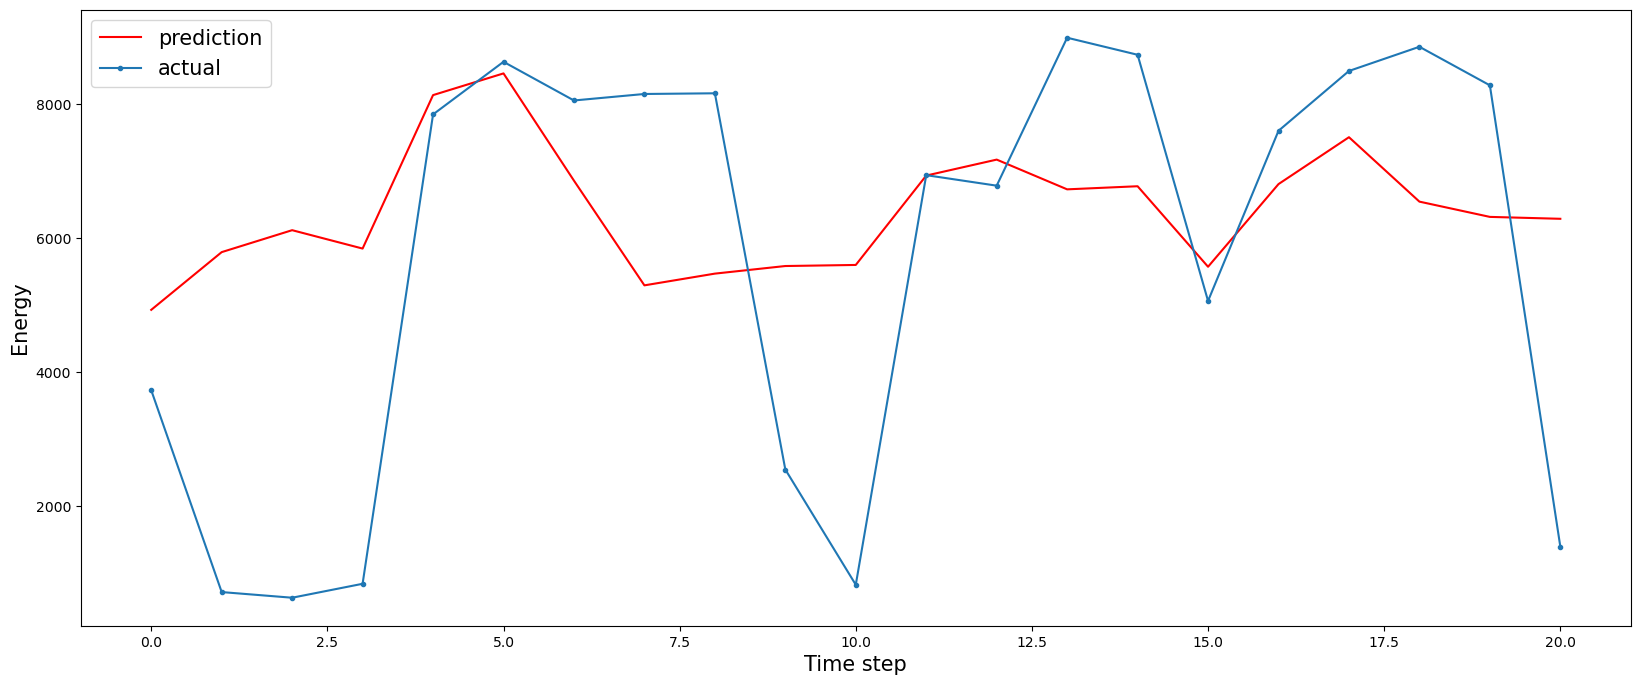

In [7]:
pyplot.figure(figsize=(20,8))
pyplot.plot(predictions, label='prediction', color="r")
pyplot.plot(original, label='actual', marker='.')
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [12]:
# data = Dataset('4h')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [13]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle= False)
print("Train sizes:")
print(X_train.shape,y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)


train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.0001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=20000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics


6299.818286496303
9193.870000001045
140.12849999964237
Train sizes:
(232, 347) (232,)
Validation sizes:
(21, 347) (21,)
Test sizes:
(21, 347) (21,)
[0]	train-rmse:0.97909	eval-rmse:1.01436


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:19:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.97022	eval-rmse:1.00522
[200]	train-rmse:0.96144	eval-rmse:0.99620
[300]	train-rmse:0.95275	eval-rmse:0.98728
[400]	train-rmse:0.94415	eval-rmse:0.97843
[500]	train-rmse:0.93564	eval-rmse:0.96967
[600]	train-rmse:0.92723	eval-rmse:0.96101
[700]	train-rmse:0.91892	eval-rmse:0.95249
[800]	train-rmse:0.91071	eval-rmse:0.94408
[900]	train-rmse:0.90257	eval-rmse:0.93577
[1000]	train-rmse:0.89452	eval-rmse:0.92754
[1100]	train-rmse:0.88655	eval-rmse:0.91942
[1200]	train-rmse:0.87866	eval-rmse:0.91142
[1300]	train-rmse:0.87084	eval-rmse:0.90353
[1400]	train-rmse:0.86310	eval-rmse:0.89575
[1500]	train-rmse:0.85545	eval-rmse:0.88808
[1600]	train-rmse:0.84786	eval-rmse:0.88051
[1700]	train-rmse:0.84036	eval-rmse:0.87305
[1800]	train-rmse:0.83293	eval-rmse:0.86568
[1900]	train-rmse:0.82558	eval-rmse:0.85842
[2000]	train-rmse:0.81831	eval-rmse:0.85126
[2100]	train-rmse:0.81110	eval-rmse:0.84421
[2200]	train-rmse:0.80405	eval-rmse:0.83717
[2300]	train-rmse:0.79714	eval-rmse:0.830

In [14]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 39))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],39))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 1395.3845899001867
Root Mean Squared Error (RMSE): 1871.4056875742829
Mean squared error (MSE): 3502159.2474853746
R² Score: 0.5112955198746264
Adjusted R² Score: 1.029890182270665


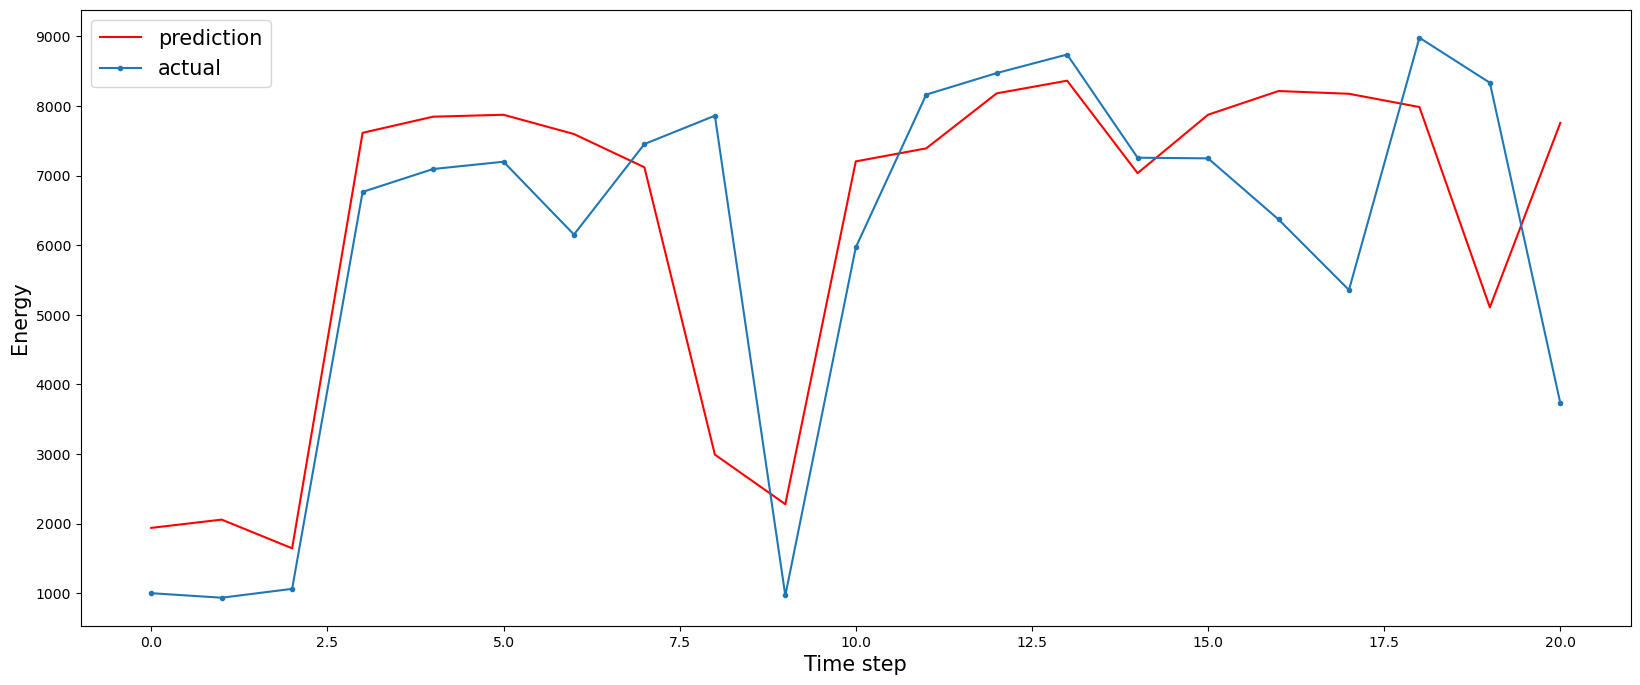

In [15]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

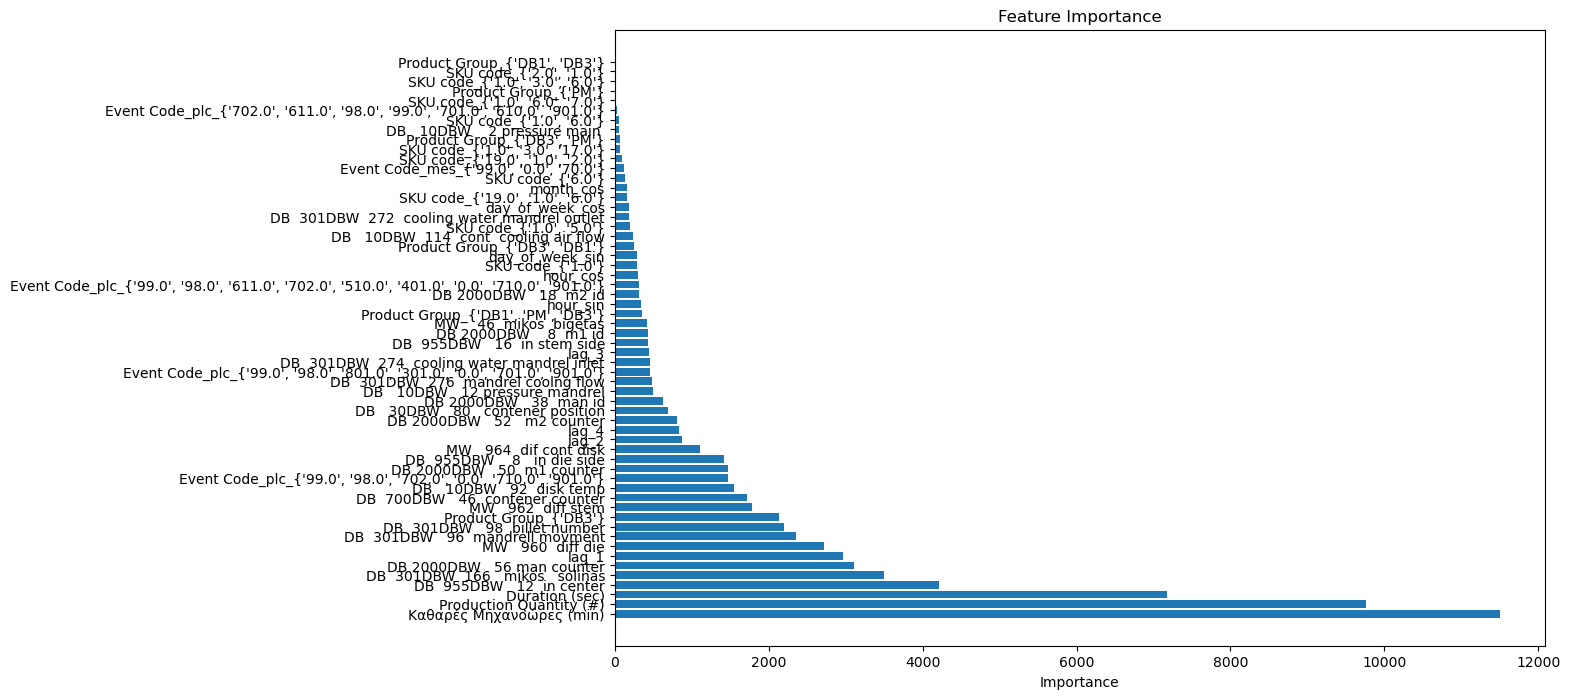

In [14]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

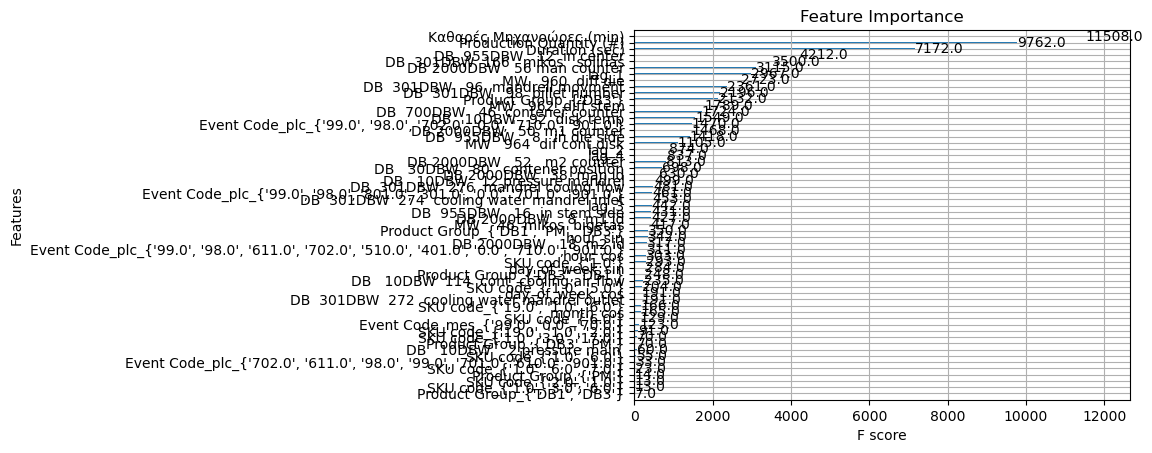

In [15]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


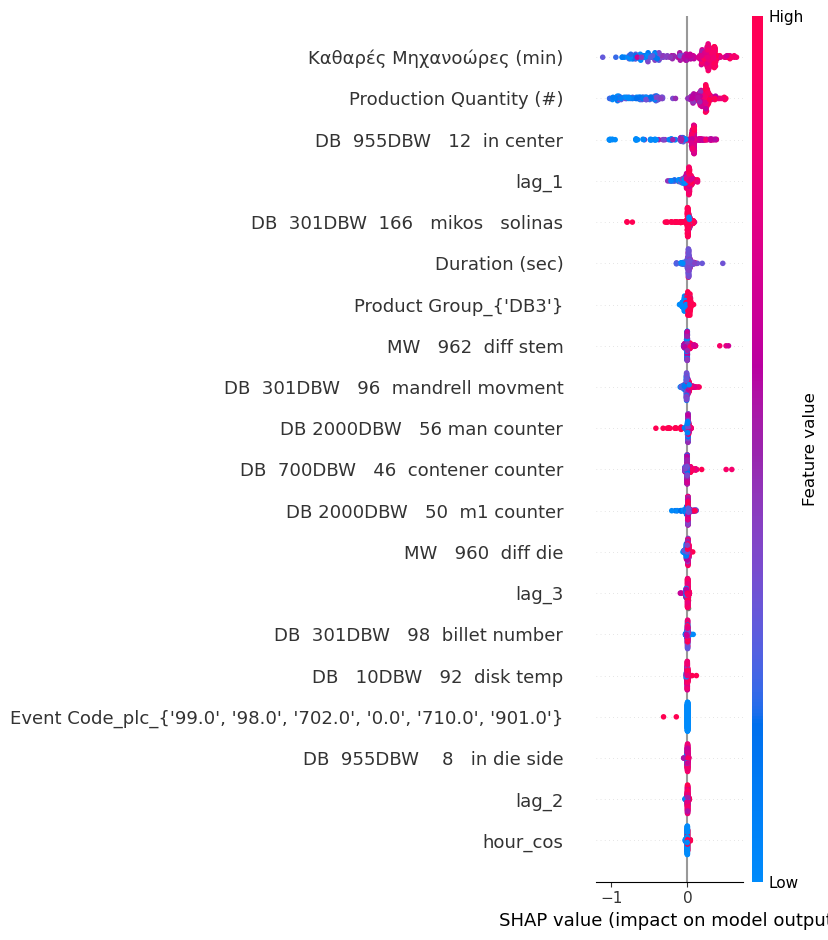

In [16]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)